# An Implementation of Fast Agglomerative Hierarchical Clustering Algorithm Using Locality-Sensitive Hashing by Walker Harrison and Lisa Lebovici (2018)

## Abstract

Agglomerative hierarchical clustering is a widely used clustering algorithm in which n data points are sequentially merged according to some distance metric from n clusters into a single cluster. While many different metrics exist to evaluate inter-cluster distance, single-linkage reigns among the most popular; according to this method, pairwise distances are computed between all points that do not share a cluster, and the clusters containing the two points with the shortest euclidean distance are joined in each iteration. However, single-linkage has some drawbacks, most noteworthy that it scales quadratically as data grows. As such, Koga, Ishibashi, and Watanbe propose using locality-sensitive hashing (hereafter LSH) as an approximation to the single-linkage method. Under LSH, points are hashed into buckets such that the distance from a given point p need only be computed to the subset of points with which it shares a bucket.

In this paper, we implement locality-sensitive hashing as a linkage method for agglomerative hierarchical clustering, optimize the code with an emphasis on reducing the time complexity of the creation of the hash tables, and apply the algorithm to a variety of synthetic and real-world data sets.

**Keywords**: agglomerative hierarchical clustering, locality-sensitive hashing, single-linkage, nearest neighbor search, dendrogram similarity, cophenetic correlation coefficient, unsupervised learning

**Github link**: https://github.com/lisalebovici/LSHLinkClustering

## Background

With the growing ease in which data can be acquired in the modern age, techniques that can accurately represent this data are becoming increasingly important. In particular, unsupervised learning - that is, data which has no "ground truth" representation - finds itself at the center of many fields ranging from consumer marketing to computer vision to genetics. At its heart, the goal of unsupervised learning is pattern recognition. To this end, algorithms such as k-means and agglomerative hierarchical clustering have been sufficiently effective until now; but as the size of data continues to grow, scalability issues are becoming a bigger barrier to analysis and understanding.

Koga et al.'s *Fast Agglomerative Hierarchical Clustering Algorithm Using Locality-Sensitive Hashing* provides a faster approximation to single-linkage hierarchical agglomerative clustering for large data, which has a run time complexity of $O(n^2)$. The single-linkage method requires that the distances from every point to all other points not in its cluster are calculated on every iteration (of which there are $n-1$ iterations in a size $n$ data set), which becomes prohibitively expensive. In contrast, the primary advantage of LSH is that it reduces the number of distances that need to be computed as well as the the number of iterations that need to run, resulting in a linear run time complexity $O(nB)$ (where $B$ is the maximum number of points in a single hash table).

However, one consequence of the gain in run time is that LSH results in a coarser approximation of the data than single-linkage; while single-linkage necessarily creates clusters ranging from size $n$ to size $1$, LSH yields far fewer iterations of clusters. This granularity can be controlled by a parameter within the algorithm, but in general it is not expected to reproduce the single-linkage method exactly. Nonetheless, when granularity is not a primary concern, the improvements in terms of efficiency make it a worthwhile alternative.

We will proceed by describing the implementation of LSH for hierarchical clustering.

## Description of Algorithm

Some important notation will first be defined:

- $n$: number of rows in data
- $d$: dimension of data
- $C$: least integer greater than the maximal coordinate value in the data
- $\ell$: number of hash functions
- $k$: number of sampled bits from a hashed value
- $r$: minimal distance between points required to merge clusters
- $A$: increase ratio of r on each iteration

LSH works in two primary phases: first, by creating a series of hash tables in which the data points are placed, and second, by computing the distances between a point and its "similar" points to determine which clusters should be merged.

**Phase 1: Generation of hash tables**. Suppose we have a d-dimensional point $x$. A unary function is applied to each coordinate value of $x$ such that $x$ 1s are followed by $C-x$ 0s. The sequence of 1s and 0s for all coordinate values of $x$ are then joined to form the hashed point of $x$. Some number $k$ bits are then sampled without replacement from the hashed point. For example, if $x$ is the point $(2, 1, 3)$ and $C = 4$, the hashed point would be $\underbrace{1100}_{2}\underbrace{1000}_{1}\underbrace{1110}_{3}$. If $k = 5$ and the indices $I = {5, 9, 2, 11, 8}$ are randomly sampled, then our resulting value would be $11110$. $x$ would thus be placed into the hash table for $11110$.

This hash function is applied to all points, and a point is added to the corresponding hash table if no other point in its cluster is already present (that is to say, hash tables, are uniqued by cluster). Another set of $k$ indices $I$ is then randomly sampled and the resulting hash function is applied to all of the points. This procedure is repeated $\ell$ times.

The intuition behind this step is as follows: a point $s$ that is very similar to $x$ is likely to have a similar hash sequence to $x$ and therefore appear in many of the same hash tables as $x$. However, for any given hash, there is no guarantee; for example, for $s = (1, 1, 3)$, the hashed point would be $\underbrace{1000}_{1}\underbrace{1000}_{1}\underbrace{1110}_{3}$ and the sampled value would be $11010$. In this cae, $s$ would not be in the same value as $x$ above. However, by applying $\ell$ hash functions to the data, we have some certainty that if $s$ is really close to $x$, it will share at least one hash table.

**Phase 2: Nearest neighbor search**. For each point $x$, we find all of the points that share at least one hash table with $x$ and are not currently in the same cluster as $x$. These are the similar points which are candidates to have their clusters merged with $x$'s cluster. The distances between $x$ and the similar points are computed, and for all points $p$ for which the euclidean distance between $x$ and $p$ is less than $r$, $p$'s clusters are merged with $x$'s cluster.

If there is more than one cluster remaining after the merges, the values for $r$ and $k$ are updated and then phases 1 and 2 are repeated. $r$ is increased (we now consider points that are a slightly further distance away than previously to merge further-away clusters) and $k$ is decreased (so that the hashed values become shorter and therefore more common). This continues until all points are in the same cluster, at which point the algorithm terminates.

#### LSH-Link Algorithm

> **Input:** Starting values for $\ell$, $k$, and $A$

> **Initialize**:

> > **if** $n < 500$

> > > sample $M = \{\sqrt{n}$ points from data}

> > > $r = \text{min dist}(p, q)$, where $p, q \in M$

> > **else**

> > > $r = \frac{d * C}{2 * (k + d)}\sqrt{d}$

> **while** num_clusters > 1:

> > **for** $i = 1,..,\ell$:

> > > $unary_C(x) = \underbrace{11...11}_{x}\underbrace{00...00}_{C-x}$

> > > sample $k$ bits from $unary_C(x)$

> > > **if** $x$'s cluster is not in hash table:

> > > > add $x$ to hash table

> > > repeat for $n$ points

> > **for** $p = 1,..,n$:

> > > S = {set of points that share at least one hash table with $p$}

> > > Q = {$q \in S$ s.t. $\text{dist}(p, q) < r$}

> > > merge $Q$'s clusters with $p$'s cluster

> > **if** num_clusters > 1:

> > > $r = A*r$

> > > $k = \frac{d * C}{2 * r}\sqrt{d}$

## Performance Optimizations

- multiprocessing or c++?

The initial version of the LSH code can be found in *Appendix A*. Note that to reproduce any of the work in the rest of this paper, all of the library and function imports can be found in the Appendix.

Run time profiling for `build_hash_tables()` and `LSHLink()` are below, as well as a comparison to scipy's single-linkage hierarchical clustering and our own implementation of agglomerative hierarchical clustering.

The three different functions were applied to an extended version of the *iris* data set; we built a set of 1,500 points based on the original 150 points with random noise added. As seen below, Scipy's implementation is clearly the superior method, running in an impressive 16.7 ms. Note that this is to be expected since a great deal of it is written in C.

In comparison, our implementation of single-linkage hierarchical clustering, written purely in python but vectorized with numpy, ran in 2 minutes 41 seconds, while the locality-sensitive hashing version ran in 2 minutes 13 seconds. A plot in the *Applications to Simulated Data Sets* section below will show that the speed advantage for LSH vs. single-linkage does not necessarily hold for smaller data sets.

Note from the profiling below that the vast majority of the run time in LSH is spent in `build_hash_tables()`; the code for nearest neighbor search and merging clusters is relatively trivial. The results show that of the 157 seconds spent running `LSHLink()`, 151 seconds were in `build_hash_tables()`. As such, nearly all of the optimization efforts were spent in speeding up the creation of the hash tables.

In [42]:
%timeit -r1 linkage(iris, method = 'single')

16.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [21]:
%timeit -r1 lsh.singleLink(1, iris)

2min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
%timeit -r1 LSHLinkv1(iris, A = 1.4, l = 10, k = 100)

2min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
%prun -q -D LSHLink.prof LSHLinkv1(iris, A = 1.4, l = 10, k = 100)

 
*** Profile stats marshalled to file 'LSHLink.prof'. 


In [15]:
p = pstats.Stats('LSHLink.prof')
p.sort_stats('time', 'cumulative').print_stats(
    'build_hash_tables')
p.sort_stats('time', 'cumulative').print_stats(
    'LSHLink')
pass

Mon Apr 30 14:18:31 2018    LSHLink.prof

         26039956 function calls in 157.957 seconds

   Ordered by: internal time, cumulative time
   List reduced from 60 to 1 due to restriction <'build_hash_tables'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        7   11.719    1.674  151.201   21.600 <ipython-input-1-b260ed9440e0>:68(build_hash_tables)


Mon Apr 30 14:18:31 2018    LSHLink.prof

         26039956 function calls in 157.957 seconds

   Ordered by: internal time, cumulative time
   List reduced from 60 to 1 due to restriction <'LSHLink'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.689    0.689  157.956  157.956 <ipython-input-1-b260ed9440e0>:93(LSHLink)




The primary optimization in the second version of the code was caching the hash points using `lru_cache()` from `functools`. By storing the hashed unary values and point representations, `build_hash_tables()` only had to compute each point's hash value on the initial run, rather than on each iteration; this was possible since a point's unary representation remains the same for a given C value, and C does not change throughout the course of the code.

The other optimization was to introduce more control logic into the nearest neighbor search. Specifically, additional "if" statements were added, such that if no points were found within distance $r$ of point $p$, that iteration of the `for` loop terminates rather than continuing on to attempt to find clusters that can be merged.

These changes reduced the run time of LSH to around 20 seconds in our tests. Run times are shown below, and the full code is available in *Appendix B*.

**FIGURE OUT TIMING ISSUES**

In [11]:
lsh.clear_caches()
%timeit -r1 lsh.LSHLink(iris, A = 1.4, l = 10, k = 100, seed1 = 12, seed2 = 6)

22.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
lsh.clear_caches()
%prun -q -D LSHLink2.prof lsh.LSHLink(iris, A = 1.4, l = 10, k = 100, seed1 = 12, seed2 = 6)

 
*** Profile stats marshalled to file 'LSHLink2.prof'. 


In [41]:
p = pstats.Stats('LSHLink2.prof')
p.sort_stats('time', 'cumulative').print_stats(
    'build_hash_tables')
p.sort_stats('time', 'cumulative').print_stats(
    'LSHLink')
pass

Mon Apr 30 17:11:59 2018    LSHLink2.prof

         452355 function calls in 20.685 seconds

   Ordered by: internal time, cumulative time
   List reduced from 45 to 1 due to restriction <'build_hash_tables'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6   16.995    2.832   18.909    3.152 <ipython-input-37-8c500c6efc8a>:87(build_hash_tables)


Mon Apr 30 17:11:59 2018    LSHLink2.prof

         452355 function calls in 20.685 seconds

   Ordered by: internal time, cumulative time
   List reduced from 45 to 1 due to restriction <'LSHLink'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.215    1.215   20.684   20.684 <ipython-input-37-8c500c6efc8a>:116(LSHLink)




## Applications to Simulated Data Sets

### Iris Data Set

The algorithm was first applied to the *iris* data set, as in the paper by Koga et al, in an effort to reproduce their results. Below, we compare the dendrograms produced from running single-linkage hierarchical clustering with our implementation of LSH under two slightly different parameterizations. In both instances, we set initial values for $k$ and $\ell$ to be 100 and 10, respectively. However, the first run of LSH has the increase ratio $A = 1.4$ while the second run has $A = 2.0$.

In [7]:
iris = datasets.load_iris().data * 10

In [4]:
z = linkage(iris, method="single")

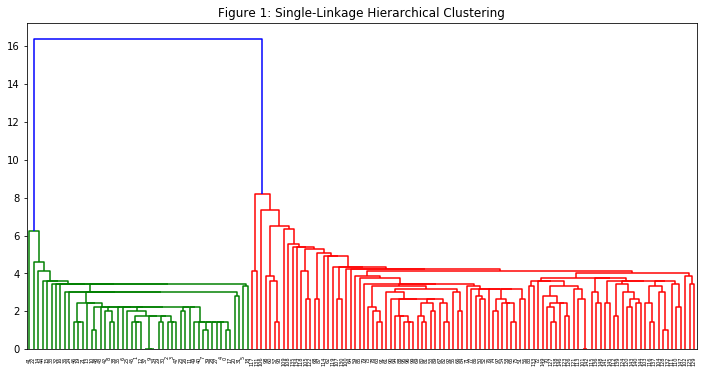

In [12]:
dendrogram(z)
plt.gcf().set_size_inches(12, 6)
plt.title('Figure 1: Single-Linkage Hierarchical Clustering')
plt.show();

In [27]:
clusters, Z = lsh.LSHLink(iris, A = 1.4, l = 10, k = 100,
                      dendrogram = True, seed1 = 12, seed2 = 6)

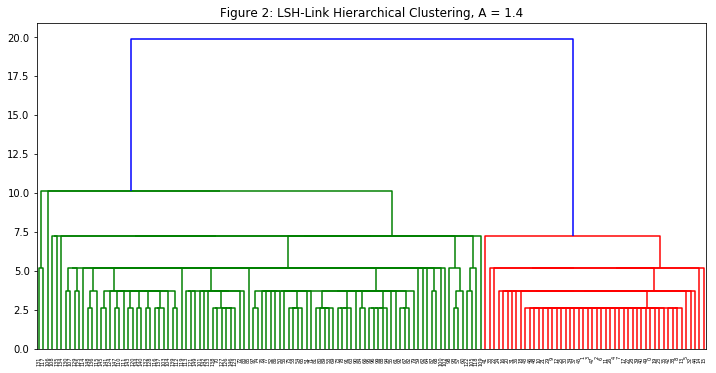

In [30]:
dendrogram(Z, color_threshold = 18)
plt.gcf().set_size_inches(12, 6)
plt.title('Figure 2: LSH-Link Hierarchical Clustering, A = 1.4')
plt.show();

In [31]:
clusters2, Z2 = lsh.LSHLink(iris, A = 2.0, l = 10, k = 100,
                        dendrogram = True, seed1 = 12, seed2 = 6)

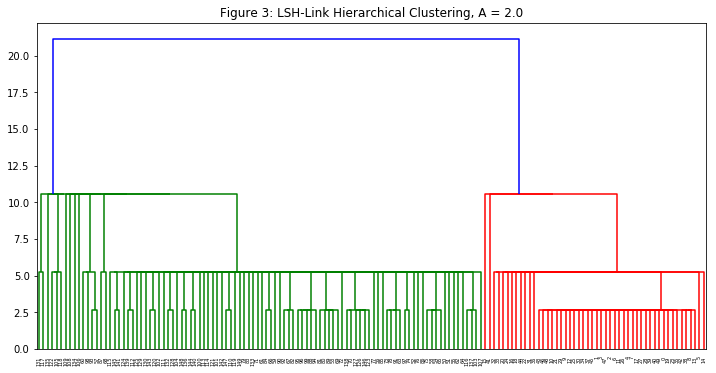

In [32]:
dendrogram(Z2, color_threshold = 18)
plt.gcf().set_size_inches(12, 6)
plt.title('Figure 3: LSH-Link Hierarchical Clustering, A = 2.0')
plt.show();

As in the paper, we have confirmed that the members of the top two clusters match perfectly across all three implementations (note that the green cluster in *Figure 1* is equivalent to the red clusters in *Figure 2* and *Figure 3*). However, as expected, the increase in $A$ corresponds to a sparser dendrogram; the algorithm is now making bigger leaps in $r$ with each iteration, so it will merge a greater number of clusters at a given time. The height of the dendrogram shows us the point in time at which two clusters merged. For single-linkage, we see that there are n-1 unique merge times, which is indeed the behavior of the single-linkage method. Under LSH with $A = 1.4$, there are six iterations of cluster merges, while under LSH with $A = 2.0$ there are only four iterations until the data is fully merged. If a high level of preciseness is not needed, however, the graphs above show that LSH does give us a rough approximation of single-linkage.

One way to measure the simularity between two dendrograms is called cophenetic correlation. For two dendograms $X$ and $Y$ it is given by

$$
r_{X,Y} = \frac{\sum_{i<j}(X_{ij}-\bar{x})(Y_{ij}-\bar{y})}
{\sqrt{\sum_{i<j}(X_{ij}-\bar{x})^2\sum_{i<j}(Y_{ij}-\bar{y})^2}}
$$

where $X_{ij}$ is the height of the node in the dendogram where points $i$ and $j$ are first joined and $\bar{x}$ is the mean of all those heights. `scipy` also provides a built-in function that applies cophenetic correlation to dendrograms.

We don't expect perfect correlation between the dendrograms created by single-linkage and LSH for two reasons. First of all, the very point of LSH is that the minimum distances are approximate so it's always possible that close points don't get bucketed by the same hashes, in which case they may meet at a node unrealistically near the root. More importantly though, the height of each node isn't controlled by distance between points but by the minimum threshold distance $r$.

That being said the correlation is _near_ perfect. Moreover, the correlation has an inverse relationship with $A$ the inter iteration multiplier $A$: as A decreases, the correlation inches closer to 1. Since $A$ can be loosely interpreted as a learning rate parameter, this relationship is intuitive—the slower we increase $r$, the more closely the algorithm approximates single linkage (or any alghorithm that considers more inter-point distances). Here we see the cophenetic correlation as calculated for three values of A: 

In [8]:
Z1 = linkage(iris, method="single")
clusters2, Z2 = lsh.LSHLink(iris, A = 2.0, l = 10, k = 100, dendrogram = True, seed1 = 12, seed2 = 6)
clusters3, Z3 = lsh.LSHLink(iris, A = 1.4, l = 10, k = 100, dendrogram = True, seed1 = 12, seed2 = 6)
clusters4, Z4 = lsh.LSHLink(iris, A = 1.2, l = 10, k = 100, dendrogram = True, seed1 = 12, seed2 = 6)

C1 = cophenet(Z1)
C2 = cophenet(Z2)
C3 = cophenet(Z3)
C4 = cophenet(Z4)
print(np.corrcoef(C1, C2)[0,1])
print(np.corrcoef(C1, C3)[0,1])
print(np.corrcoef(C1, C4)[0,1])

0.9904974707929263
0.9987309030621808
0.9992070012882861


In addition to analyzing accuracy between single-linkage and LSH, we must look at performance. To some extent, it is possible to control the run time for LSH by changing the initial parameters, particularly A. Setting a larger starting value for A will result in a coarser but quicker run, while a smaller value will provide a slower and finer approximation. The size of the data also plays a significant role. For small data sets, single-linkage can be equivalent to or even outperform LSH. This is due to the fact that LSH has non-trivial overhead in computing the hash tables for each iteration; when there are not many data points, it can be slower to calculate the hash values on each iteration than to just do $n - 1$ merges as in single-linkage. As the data set grows however, LSH scales linearly ($O(n)$)  while single-linkage scales quadratically ($O(n^2)$). This is when LSH becomes particularly useful, as long as a high degree of precision is not needed.

Below, we show the run time in seconds on an enlarged *iris* data set (with noise added as mentioned above) on four different hierarchical clustering implementations: scipy's single-linkage, our implementation of single-linkage, LSH with $A = 1.4$, and LSH with $A = 2.0$. Due to prohibitive run times on our single-linkage implementation for large data sets, we have only shown up to 3,000 data points.

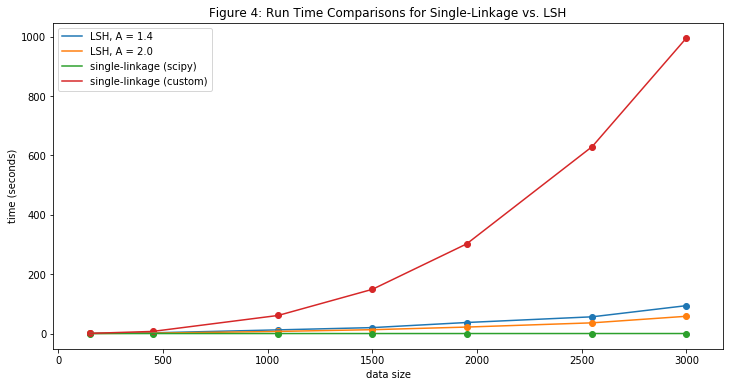

In [7]:
iris_run_times()

Scipy is clearly orders of magnitude faster and is only shown above as an example of the theoretical possibility for LSH. For analysis purposes, we look at our custom implementation of single-linkage compared to LSH under the two different parameterizations $A = 1.4$ and $A = 2.0$. The single-linkage method clearly grows quadratically and performs relatively worse as the data size increases; on the other hand, LSH performs nearly linearly (we would expect that fully optimized code would have precisely linear run time). We observe that, although for small data sets LSH does not represent a necessary improvement, the gains in efficiency for larger data can be substantial.

### Synthetic Data of Abstract Shapes

We now illustrate our implementation of LSH for agglomerative hierarchical clustering on several generated data sets containing different shapes.

We start with a data set of 200 data points, replicating synthetic data from the Koga et al. paper:

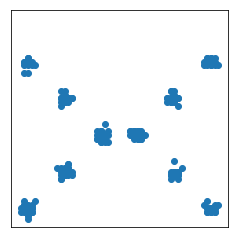

In [3]:
tencircles = np.genfromtxt('../data/tencircles.csv', delimiter=",")
lsh.plot_square(tencircles)

Running our implementation of LSH clustering on this data, with a cutoff of 10 clusters, yields the following:

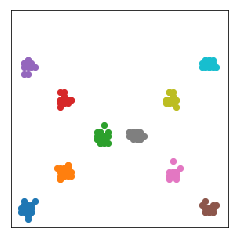

In [4]:
lsh.plot_clusters(tencircles, cutoff=10, scale=10, linkage='LSH', A=1.4, k=10, l=100)

As clearly shown, the algorithm successfully identifies the ten clusters that are visible to the human eye. Intuitively, a researcher might also identify a way to break the data into two clusters: the five groups on the left and the five groups on the right. The algorithm, however, fails to capture this:

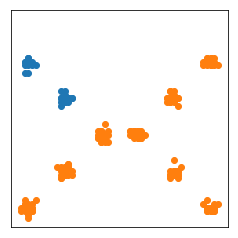

In [18]:
lsh.plot_clusters(tencircles, cutoff=2, scale=10, linkage='LSH', A=1.2, k=10, l=100)

This could potentially be improved by changing some combination of the parameters set by the researcher, $A$, $k$, or $\ell$. It is worth noting that the two center groups do appear closer to each other than does the center left with the two top left groups, so it is not unreasonable to expect that the algorithm would fail to recognize the pattern.

Now we turn to two other fabricated data sets in different shapes: the classic spiral that is often the canonical example for agglomerative hierarchical clustering (300 points) and a data set with clusterings of different kinds of shapes (500 points). In both instances, the algorithm successfully identifies what we would perceive to be distinct clusters.

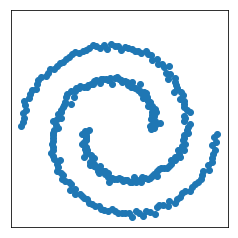

In [6]:
spirals = np.genfromtxt('../data/spirals.csv', delimiter=",")[1:, 1:]
lsh.plot_square(spirals)

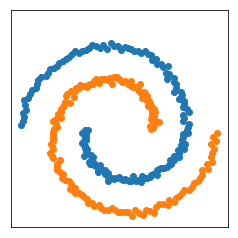

In [7]:
lsh.plot_clusters(spirals, cutoff=2, scale=100, linkage='LSH', A=1.4, k=10, l=100)

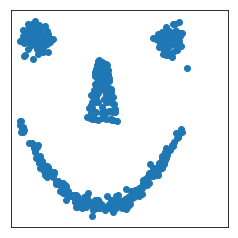

In [10]:
smiley = np.genfromtxt('../data/smiley.csv', delimiter=",")[1:, 1:]
lsh.plot_square(smiley)

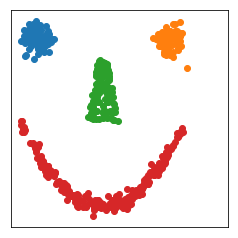

In [9]:
lsh.plot_clusters(smiley, cutoff=4, scale=100, linkage='LSH', A=1.4, k=10, l=100)

## Applications to Real Data Sets

- gene data from paper? (use pca to collapse to two dimensions and plot?)
- find another data set

In [3]:
kershaw = pd.read_csv('../data/Kershaw.csv').iloc[:, 1:5]
kershaw_data = np.array(kershaw.iloc[:, 0:3])
kershaw_labels = np.array(kershaw.iloc[:, 3])

a = np.array([0])
b = np.min(kershaw_data, axis = 0)[1:3]
shift = np.r_[a, b]
kershaw_data_shifted = kershaw_data - shift
kersh_clusters = lsh.LSHLink(kershaw_data_shifted, A = 1.4, l = 10, k = 100, seed1 = 12, seed2 = 6, cutoff = 2)

In [41]:
kersh_full = np.c_[kershaw_data, kersh_clusters]

In [ ]:
g1 = np.where(kersh_clusters == np.unique(kersh_clusters)[0])[0]
g2 = np.where(kersh_clusters == np.unique(kersh_clusters)[1])[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kersh_full[g1, 0], kersh_full[g1, 1], kersh_full[g1, 2], alpha = 0.4, c = 'red')
ax.scatter(kersh_full[g2, 0], kersh_full[g2, 1], kersh_full[g2, 2], alpha = 0.4, c = 'blue')
ax.view_init(azim=200)
ax.set_xlabel('Speed')
ax.set_ylabel('Horizontal Break')
ax.set_zlabel('Vertical Break')
plt.show()

In [ ]:
class_LSH = kersh_clusters == 32
class_TRUE = kershaw_labels == 'FF'
sum(np.equal(class_LSH, class_TRUE))/kershaw.shape[0]

## Comparative Analysis with Competing Algorithms

- walker?

LSH performs similarly well to single-linkage in terms of being able to identify highly non-spherical or long/thin patterns in data, which makes it somewhat more flexible compared to a method like k-means.

## Discussion / Conclusion

discussion ideas:
- implementing noise exclusion option
- better approximation by fully implementing in c++
- select parameters automatically (e.g. use $P_{miss}$ from bottom of pg32 to do a grid search for $\ell$)

## References / Bibliography

- third data set?

1. Eaves IA, Wicker LS, Ghandour G, Lyons PA et al. Combining mouse congenic strains and microarray gene expression analyses to study a complex trait: the NOD model of type 1 diabetes. Genome Res 2002 Feb;12(2):232-43. PMID: 11827943
2. Koga H, Ishibashi T, Watanabe T (2006) Fast agglomerative hierarchical clustering algorithm using Locality-Sensitive Hashing. In: Knowledge and Information Systems 12(1): 25-53

## Appendices

### Appendix A

In [2]:
import lshlink as lsh
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from functools import reduce, lru_cache
import datetime
import pickle
import pstats
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def data_extend(data, k):
    r, c = data.shape
    data_extend = (reduce(lambda x, y: np.vstack((x, y)),
                          map(lambda x: data, range(k))) +
                  np.random.randn(r*c*k).reshape(r*k, c).round(1))
    return(data_extend)

iris = datasets.load_iris().data
iris = data_extend(iris, 10) * 10
iris += np.abs(np.min(iris))

l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

In [23]:
def unary(x, C):
    nearest_x = int(np.round(x))
    return((np.r_[np.ones(nearest_x),
                  np.zeros(C-nearest_x)]))

def lsh_hash(point, C):
    res = np.concatenate(list(map(lambda x: unary(x, C), point)))
    return(res)

def get_points_in_cluster(idx, clusters, data):
    point_cluster = clusters[idx]
    same_cluster_points_idx = np.where(
        clusters == point_cluster
    )[0]
    same_cluster_points = set(
        map(tuple, data[same_cluster_points_idx, :])
    )
    return same_cluster_points

def get_point_indices(data, points):
    indices = np.where((data == points[:,None]).all(-1))[1]
    return indices

def build_hash_tables(C, d, l, k, data, clusters):
    vals = np.arange(C*d)
    n = data.shape[0]
    hash_tables = defaultdict(set)
    hash_tables_reversed = defaultdict(set)

    for i in range(l):
        I = np.random.choice(vals, k, replace = False)

        for j in range(n):
            # for every point, generate hashed point
            # and sample k bits
            p = data[j]
            hashed_point = lsh_hash(p, C)[I]
            
            # check if any other points in p's cluster are
            # already in this hash table
            # and only add point to hash table if no other
            # points from its cluster are there
            bucket = hash_tables[tuple(hashed_point)]
            cluster_points = get_points_in_cluster(j, clusters, data)
            
            # create unique bucket for each hash function
            key = tuple([i]) + tuple(hashed_point)

            if not cluster_points.intersection(bucket):
                hash_tables[key].add(tuple(p))
                hash_tables_reversed[tuple(p)].add(key)

    return hash_tables, hash_tables_reversed

def LSHLinkv1(data, A, l, k, C = None, cutoff = 1):
    # set default value for C if none is provided
    if not C:
        C = int(np.ceil(np.max(data))) + 1
    
    # initializations
    n, d = data.shape
    clusters = np.arange(n)
    unique_clusters = len(np.unique(clusters))
    num = n - 1
    Z = np.zeros((n - 1, 4))
    
    # calculate r depending on n, either:
    # 1. min dist from a random sample of sqrt(n) points
    # 2. formula below
    np.random.seed(12)
    n_samp = int(np.ceil(np.sqrt(n)))
    samples = data[np.random.choice(
        n, size = n_samp, replace = False), :]
    
    if n < 500:
        r = np.min(pdist(samples, 'euclidean'))
    else:
        r = (d * C * np.sqrt(d)) / (2 * (k + d))
    
    np.random.seed(6)
    while unique_clusters > cutoff:
        # STEP 1: Generation of hash tables
        hash_tables, hash_tables_reversed = build_hash_tables(
            C, d, l, k, data, clusters)

        # STEP 2: Nearest neighbor search for p
        for i in range(n):
            # get all of those hash tables that contain point p
            p = data[i]
            p_hashes = hash_tables_reversed[tuple(p)]

            # only proceed if p is in at least one hash table
            if hash_tables_reversed[tuple(p)]:

                # find all "similar points" to p: points that
                # share at least one hash table with p, and are
                # not in the same cluster as p
                similar_points = reduce(
                    lambda x, y: x.union(y),
                    map(lambda x: hash_tables[x], p_hashes)
                    ).difference(
                    get_points_in_cluster(i, clusters, data)
                )
                similar_points = np.array(list(similar_points))

                # STEP 3: Connect pairs of clusters within certain
                # distance of p; only proceed if p has any similar points
                if similar_points.size:

                    # find similar points q s.t. dist(p, q) < r
                    # the clusters containing these points will
                    # be merged with p's cluster
                    points_to_merge = similar_points[
                        np.where(np.linalg.norm(
                            p - similar_points, axis = 1
                        ) < r)[0]
                    ]

                    # identify which clusters contain points_to_merge
                    clusters_to_merge = clusters[np.where(
                        (iris == points_to_merge[:,None]).all(-1)
                    )[1]]

                    # update cluster labels
                    clusters[np.where(
                        np.in1d(clusters,clusters_to_merge)
                    )[0]] = clusters[i]

        # STEP 4: update parameters and continue until
        # unique_clusters == cutoff
        unique_clusters = len(np.unique(clusters))

        #increase r and decrease k
        r *= A
        k = int(np.round((d * C * np.sqrt(d)) / (2 * r)))

    return(clusters)

### Appendix B

In [46]:
@lru_cache(maxsize=None)
def unary(x, C):
    nearest_x = int(np.round(x))
    return(np.r_[np.ones(nearest_x), np.zeros(C-nearest_x)])

@lru_cache(maxsize=None)
def lsh_hash(point, C):
    point = np.array(point)
    res = np.concatenate(list(map(lambda x: unary(x, C), point)))
    return(res)

@lru_cache(maxsize=None)
def get_points_in_cluster(idx, clusters, data):
    clusters = np.array(clusters)
    data = pickle.loads(data)
    point_cluster = clusters[idx]
    same_cluster_points_idx = np.where(
        clusters == point_cluster)[0]
    same_cluster_points = set(
        map(tuple, data[same_cluster_points_idx, :])
    )
    return(same_cluster_points)

@lru_cache(maxsize=None)
def get_point_indices(data, points):
    data = pickle.loads(data)
    points = pickle.loads(points)
    indices = np.where((data == points[:,None]).all(-1))[1]
    return(indices)

def build_hash_tables(C, d, l, k, data, clusters):
    vals = np.arange(C*d)
    n = data.shape[0]
    hash_tables = defaultdict(set)
    hash_tables_reversed = defaultdict(set)

    for i in range(l):
        I = np.random.choice(vals, k, replace = False)

        for j in range(n):
            # for every point, generate hashed point
            # and sample k bits
            p = data[j]
            hashed_point = lsh_hash(tuple(p), C)[I]
            
            # check if any other points in p's cluster are
            # already in this hash table and only add point to
            # hash table if no other points from its cluster are there
            bucket = hash_tables[tuple(hashed_point)]
            cluster_points = get_points_in_cluster(
                j, tuple(clusters), pickle.dumps(data)
            )
            
            # create unique bucket for each hash function
            key = tuple([i]) + tuple(hashed_point)

            if not cluster_points.intersection(bucket):
                hash_tables[key].add(tuple(p))
                hash_tables_reversed[tuple(p)].add(key)
    
    return hash_tables, hash_tables_reversed

def LSHLinkv2(data, A, l, k, C = None, cutoff = 1, dendrogram = False, **kwargs):
    # set default value for C if none is provided
    if not C:
        C = int(np.ceil(np.max(data))) + 1
    
    if dendrogram and cutoff != 1:
        raise Exception(
            'Dendrogram requires a full hierarchy; set cutoff to 1'
        )
    
    # initializations
    n, d = data.shape
    clusters = np.arange(n)
    unique_clusters = len(np.unique(clusters))
    num = n - 1
    Z = np.zeros((n - 1, 4))
    
    # calculate r depending on n, either:
    # 1. min dist from a random sample of sqrt(n) points
    # 2. formula below
    
    if 'seed1' in kwargs and isinstance(kwargs['seed1'], int):
        np.random.seed(kwargs['seed1'])
        
    n_samp = int(np.ceil(np.sqrt(n)))
    samples = data[
        np.random.choice(n, size = n_samp, replace = False), :]
    
    if n < 500:
        r = np.min(pdist(samples, 'euclidean'))
    else:
        r = (d * C * np.sqrt(d)) / (2 * (k + d))
    
    if 'seed2' in kwargs and isinstance(kwargs['seed2'], int):
        np.random.seed([kwargs['seed2']])

    while unique_clusters > cutoff:
        # STEP 1: Generation of hash tables
        hash_tables, hash_tables_reversed = build_hash_tables(
            C, d, l, k, data, clusters)

        # STEP 2: Nearest neighbor search for p
        for i in range(n):
            # get all of those hash tables that contain point p
            p = data[i]
            p_hashes = hash_tables_reversed[tuple(p)]

            # only proceed if p is in at least one hash table
            if hash_tables_reversed[tuple(p)]:

                # find all "similar points" to p: points that share
                # at least one hash table with p, and are not in the
                # same cluster as p
                similar_points = reduce(
                    lambda x, y: x.union(y),
                    map(lambda x: hash_tables[x], p_hashes)
                    ).difference(
                    get_points_in_cluster(i, tuple(clusters),
                                          pickle.dumps(data))
                )
                similar_points = np.array(list(similar_points))

                # STEP 3: Connect pairs of clusters within certain
                # distance of p
                # only proceed if p has any similar points
                if similar_points.size:

                    # find similar points q s.t. dist(p, q) < r
                    # the clusters containing these points will be
                    # merged with p's cluster
                    points_to_merge = similar_points[
                        np.where(
                            np.linalg.norm(p - similar_points, axis = 1) < r
                        )[0]
                    ]

                    # only proceed if p has similar points within distance r
                    if points_to_merge.size:
                        # identify which clusters contain points_to_merge
                        point_indices = get_point_indices(
                            pickle.dumps(data),
                            pickle.dumps(points_to_merge)
                        )
                        clusters_to_merge = list(
                            np.unique(clusters[point_indices])
                        )
                        
                        # update cluster labels
                        # if dendrogram = False, we can use a simpler method
                        if not dendrogram:
                            clusters[
                                np.where(np.in1d(clusters, clusters_to_merge)
                                        )[0]] = clusters[i]
                        
                        else:
                            clusters_to_merge.append(clusters[i])
                            
                            for j in range(len(clusters_to_merge) - 1):
                                clusterA = clusters_to_merge[j]
                                clusterB = clusters_to_merge[j+1]
                                num += 1
                                clusters[np.where(
                                    np.in1d(clusters, [clusterA, clusterB])
                                )[0]] = num

                                Z[num - n, :] = np.array(
                                    [clusterA,
                                     clusterB,
                                     r,
                                     len(np.where(np.in1d(clusters, num))[0])]
                                )
                                clusters_to_merge[j:j+2] = 2 * [num]

        # STEP 4: update parameters and continue until
        # unique_clusters == cutoff
        unique_clusters = len(np.unique(clusters))

        #increase r and decrease k
        r *= A
        k = int(np.round((d * C * np.sqrt(d)) / (2 * r)))

    if not dendrogram:
        return(clusters)
    
    else:
        return(clusters, Z)

### Appendix C

Data and matplotlib code for Figure 4:

In [2]:
lsh_A14_y = [.46, 2.37, 12.4, 20, 37.2, 56.4, 94]
lsh_A14_x = [150, 450, 1050, 1500, 1950, 2550, 3000]

lsh_A20_x = [150, 450, 1050, 1500, 1950, 2550, 3000]
lsh_A20_y = [.285, 1.31, 7.15, 13, 21.8, 36.1, 58.2]

sci_x = [150, 450, 1050, 1500, 1950, 2550, 3000]
sci_y = [0.000215, 0.00136, 0.00996, 0.0187, 0.0341, 0.0592, 0.0843]

single_x = [150, 450, 1050, 1500, 1950, 2550, 3000]
single_y = [0.530, 7.13, 61, 149, 302, 630, 996]

In [6]:
def iris_run_times():
    plt.scatter(lsh_A14_x, lsh_A14_y)
    plt.plot(lsh_A14_x, lsh_A14_y, label = 'LSH, A = 1.4')
    plt.scatter(lsh_A20_x, lsh_A20_y)
    plt.plot(lsh_A20_x, lsh_A20_y, label = 'LSH, A = 2.0')
    plt.scatter(sci_x, sci_y)
    plt.plot(sci_x, sci_y, label = 'single-linkage (scipy)')
    plt.scatter(single_x, single_y)
    plt.plot(single_x, single_y, label = 'single-linkage (custom)')
    plt.legend(loc = 'upper left')
    plt.xlabel('data size')
    plt.ylabel('time (seconds)')
    plt.title('Figure 4: Run Time Comparisons for Single-Linkage vs. LSH')
    plt.gcf().set_size_inches(12, 6)
    plt.show();